In [ ]:
!pip install -q torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        def conv_block(i, o):
            return nn.Sequential(
                nn.Conv2d(i, o, 3, padding=1),
                nn.BatchNorm2d(o),
                nn.ReLU(inplace=True),
                nn.Conv2d(o, o, 3, padding=1),
                nn.BatchNorm2d(o),
                nn.ReLU(inplace=True),
            )

        self.down1 = conv_block(in_channels, 64)
        self.down2 = conv_block(64, 128)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up1 = conv_block(128, 64) 

    
        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
    
        x1 = self.down1(x) 
        x_pooled1 = self.pool(x1) 
        x2 = self.down2(x_pooled1) 
        x_pooled2 = self.pool(x2) 

        x_mid = self.bottleneck(x_pooled2) 

    
        x_up2 = self.upconv2(x_mid) 
        x = torch.cat([x_up2, x2], dim=1) 
        x = self.up2(x)  

        x_up1 = self.upconv1(x) 
        x = torch.cat([x_up1, x1], dim=1) 
        x = self.up1(x)

       
        return self.out(x) 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet().to(device)

print(f"Model loaded on {device}")

dummy_input = torch.randn(2, 3, 32, 32).to(device)
output_shape = model(dummy_input).shape
print(f"Test output shape: {output_shape}")

Model loaded on cuda
Test output shape: torch.Size([2, 3, 32, 32])


In [ ]:
def c_gamma_truncated(gamma, a=0.8, lambda_mult=4.0):

    a_tensor = torch.tensor(a, device=gamma.device)

    c = torch.where(
        gamma <= a_tensor,
        torch.tensor(1.0, device=gamma.device),
        (1.0 - gamma) / (1.0 - a)
    )
    return lambda_mult * c

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()



In [ ]:
@torch.no_grad()

def enhance_image(model, x_dark, num_steps=50, eta=0.1):

    model.eval()
    x_k = x_dark.clone()

    history = [x_k.cpu()]

    for k in range(num_steps):

        pred_grad = model(x_k)

        x_k = x_k - eta * pred_grad

        if (k + 1) % 5 == 0:
            history.append(x_k.cpu())

    x_enhanced = x_k.clamp(0.0, 1.0)
    history.append(x_enhanced.cpu())

    return x_enhanced, history

In [ ]:
!pip install -q kagglehub

In [ ]:
import kagglehub
import os
from PIL import Image

In [ ]:
path = kagglehub.dataset_download("soumikrakshit/lol-dataset")

print("Path to dataset files:", path)

100%|██████████| 331M/331M [00:02<00:00, 131MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/soumikrakshit/lol-dataset/versions/1


In [ ]:
TRAIN_LOW_DIR = os.path.join(path, 'lol_dataset/our485/low')
TRAIN_HIGH_DIR = os.path.join(path, 'lol_dataset/our485/high')
TEST_LOW_DIR = os.path.join(path, 'lol_dataset/eval15/low')
TEST_HIGH_DIR = os.path.join(path, 'lol_dataset/eval15/high')

print(f"Train low dir exists: {os.path.exists(TRAIN_LOW_DIR)}")
print(f"Train high dir exists: {os.path.exists(TRAIN_HIGH_DIR)}")

Train low dir exists: True
Train high dir exists: True


In [ ]:
PATCH_SIZE = 128
train_transform = transforms.Compose([
    transforms.Resize(PATCH_SIZE),
    transforms.RandomCrop(PATCH_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(PATCH_SIZE),
    transforms.CenterCrop(PATCH_SIZE),
    transforms.ToTensor(),
])

class PairedImageDataset(Dataset):
    def __init__(self, low_dir, high_dir, transform=None):
        self.low_dir = low_dir
        self.high_dir = high_dir
        self.transform = transform

        self.low_images = sorted(os.listdir(low_dir))
        self.high_images = sorted(os.listdir(high_dir))

        assert len(self.low_images) == len(self.high_images), "Mismatch in image counts"
        print(f"Found {len(self.low_images)} paired images.")

    def __len__(self):
        return len(self.low_images)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.low_images[idx])
        high_img_path = os.path.join(self.high_dir, self.high_images[idx])

        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.transform:
            seed = torch.randint(0, 2**32, (1,)).item()

            torch.manual_seed(seed)
            x_dark = self.transform(low_img)

            torch.manual_seed(seed)
            x_light = self.transform(high_img)

        return x_light, x_dark

In [ ]:
train_dataset = PairedImageDataset(TRAIN_LOW_DIR, TRAIN_HIGH_DIR, transform=train_transform)
test_dataset = PairedImageDataset(TEST_LOW_DIR, TEST_HIGH_DIR, transform=test_transform)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created. Training on {len(train_dataset)} images.")
print(f"Testing on {len(test_dataset)} images.")

Found 485 paired images.
Found 15 paired images.
DataLoaders created. Training on 485 images.
Testing on 15 images.


In [ ]:
model = SimpleUNet().to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
def calculate_eqm_loss(model, x_light, x_dark):

    B = x_light.shape[0]
    dev = x_light.device


    gamma = torch.rand(B, 1, 1, 1, device=dev)

    x_gamma = gamma * x_light + (1.0 - gamma) * x_dark

    target_direction = x_dark - x_light

    c = c_gamma_truncated(gamma)

    target = target_direction * c

    pred_grad = model(x_gamma)

    loss = criterion(pred_grad, target)
    return loss

In [ ]:
NUM_EPOCHS = 30

model.train()
for epoch in range(NUM_EPOCHS):
    total_loss = 0

    for batch_idx, (x_light, x_dark) in enumerate(train_loader):

        x_light = x_light.to(device)
        x_dark = x_dark.to(device)

        optimizer.zero_grad()


        loss = calculate_eqm_loss(model, x_light, x_dark)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 20 == 0:
            print(f"  [Epoch {epoch+1:02d}/{NUM_EPOCHS}, Batch {batch_idx:03d}/{len(train_loader)}] Loss: {loss.item():.6f}")

    avg_loss = total_loss / len(train_loader)
    print(f"===> Epoch {epoch+1} Complete: Avg. Loss: {avg_loss:.6f}")


  [Epoch 01/30, Batch 000/31] Loss: 2.340444
  [Epoch 01/30, Batch 020/31] Loss: 2.405868
===> Epoch 1 Complete: Avg. Loss: 2.117936
  [Epoch 02/30, Batch 000/31] Loss: 1.820874
  [Epoch 02/30, Batch 020/31] Loss: 1.604800
===> Epoch 2 Complete: Avg. Loss: 1.485633
  [Epoch 03/30, Batch 000/31] Loss: 1.206136
  [Epoch 03/30, Batch 020/31] Loss: 1.051107
===> Epoch 3 Complete: Avg. Loss: 1.259124
  [Epoch 04/30, Batch 000/31] Loss: 0.792376
  [Epoch 04/30, Batch 020/31] Loss: 1.384979
===> Epoch 4 Complete: Avg. Loss: 1.123585
  [Epoch 05/30, Batch 000/31] Loss: 0.889105
  [Epoch 05/30, Batch 020/31] Loss: 0.899232
===> Epoch 5 Complete: Avg. Loss: 0.949663
  [Epoch 06/30, Batch 000/31] Loss: 0.750910
  [Epoch 06/30, Batch 020/31] Loss: 0.836324
===> Epoch 6 Complete: Avg. Loss: 0.881965
  [Epoch 07/30, Batch 000/31] Loss: 0.939979
  [Epoch 07/30, Batch 020/31] Loss: 0.525457
===> Epoch 7 Complete: Avg. Loss: 0.832536
  [Epoch 08/30, Batch 000/31] Loss: 0.675848
  [Epoch 08/30, Batch 02

In [ ]:
import os
print(os.path.exists("EqM_Enhancer_LOL_v1.pt"))

True


In [ ]:

def prep_for_plot(tensor):
    return tensor.cpu().permute(1, 2, 0).numpy()


def plot_results(x_dark, x_enhanced, x_light):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(prep_for_plot(x_dark))
    axes[0].set_title("Input (Dark)")
    axes[0].axis('off')

    axes[1].imshow(prep_for_plot(x_enhanced))
    axes[1].set_title("Output (Enhanced)")
    axes[1].axis('off')

    axes[2].imshow(prep_for_plot(x_light))
    axes[2].set_title("Ground Truth (Light)")
    axes[2].axis('off')

    plt.show()

def plot_history(history):
    num_images = len(history)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

    for i, img in enumerate(history):
        axes[i].imshow(prep_for_plot(img.squeeze(0)))
        axes[i].set_title(f"Step {i * 5 if i > 0 else 0}")
        axes[i].axis('off')
    axes[-1].set_title("Final")

    plt.show()


--- Test Image 1 ---


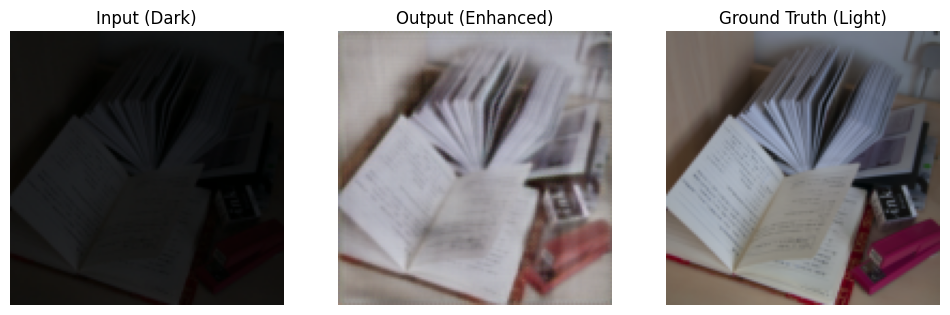

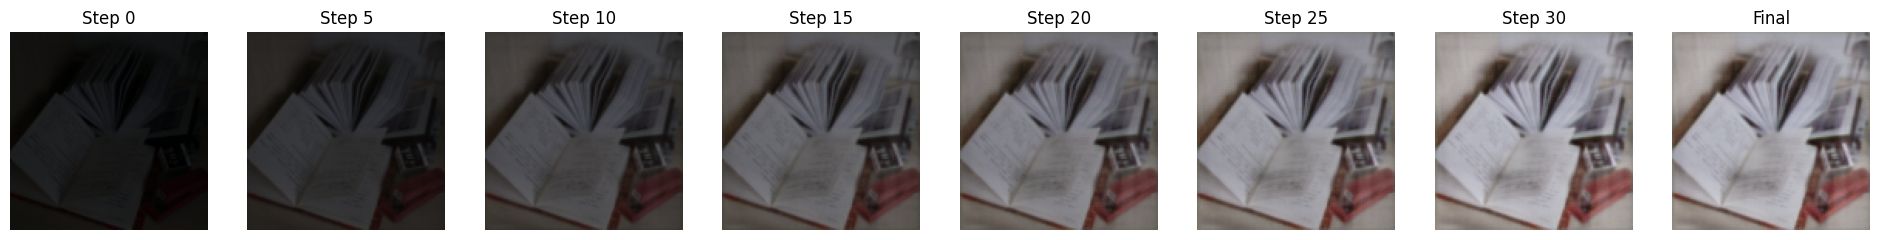


--- Test Image 2 ---


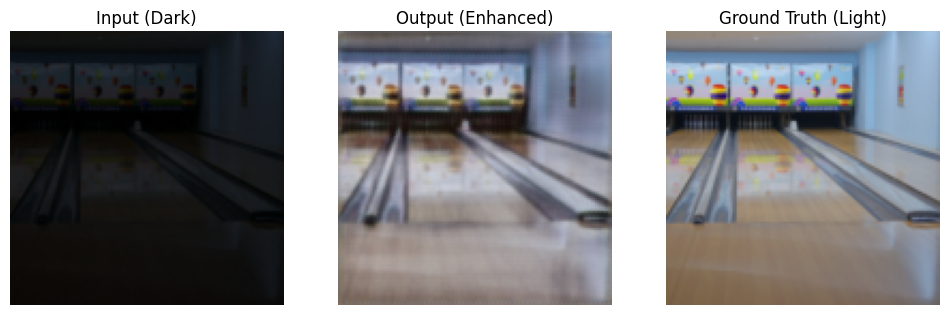

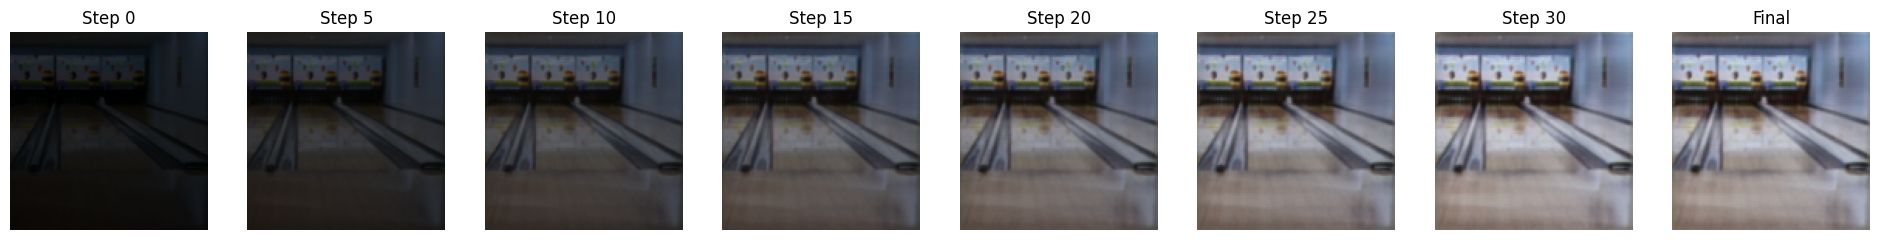

In [ ]:

MODEL_PATH = "EqM_Enhancer_LOL_v1.pt"

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

model = model.to(device)

model.eval()


x_light_test_batch, x_dark_test_batch = next(iter(test_loader))


x_light_test_batch = x_light_test_batch.to(device)
x_dark_test_batch = x_dark_test_batch.to(device)


print("\n--- Test Image 1 ---")
test_idx = 7
x_d = x_dark_test_batch[test_idx].unsqueeze(0)
x_l = x_light_test_batch[test_idx]

x_e, history = enhance_image(model, x_d, num_steps=30, eta=0.01)


plot_results(x_d.squeeze(0), x_e.squeeze(0), x_l)
plot_history(history)



print("\n--- Test Image 2 ---")
test_idx = 10
x_d = x_dark_test_batch[test_idx].unsqueeze(0)
x_l = x_light_test_batch[test_idx]
x_e, history = enhance_image(model, x_d, num_steps=30, eta=0.01)
plot_results(x_d.squeeze(0), x_e.squeeze(0), x_l)
plot_history(history)

In [ ]:
MODEL_PATH = "EqM_Enhancer_LOL_v1.pt"

torch.save(model.state_dict(), MODEL_PATH)

print(f"Model weights saved to: {MODEL_PATH}")

Model weights saved to: EqM_Enhancer_LOL_v1.pt
